In [1]:
!pip install uncertainty-toolbox


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


Saved figure row_1.svg
MACE: 0.19429230769230776, RMSCE: 0.21753026807398695, MA: 0.1962548562548563
Saved figure row_2.svg
MACE: 0.20692307692307693, RMSCE: 0.23002988045213346, MA: 0.20901320901320897
Saved figure row_3.svg
MACE: 0.008618026418026406, RMSCE: 0.010400269264830841, MA: 0.008645821828385835


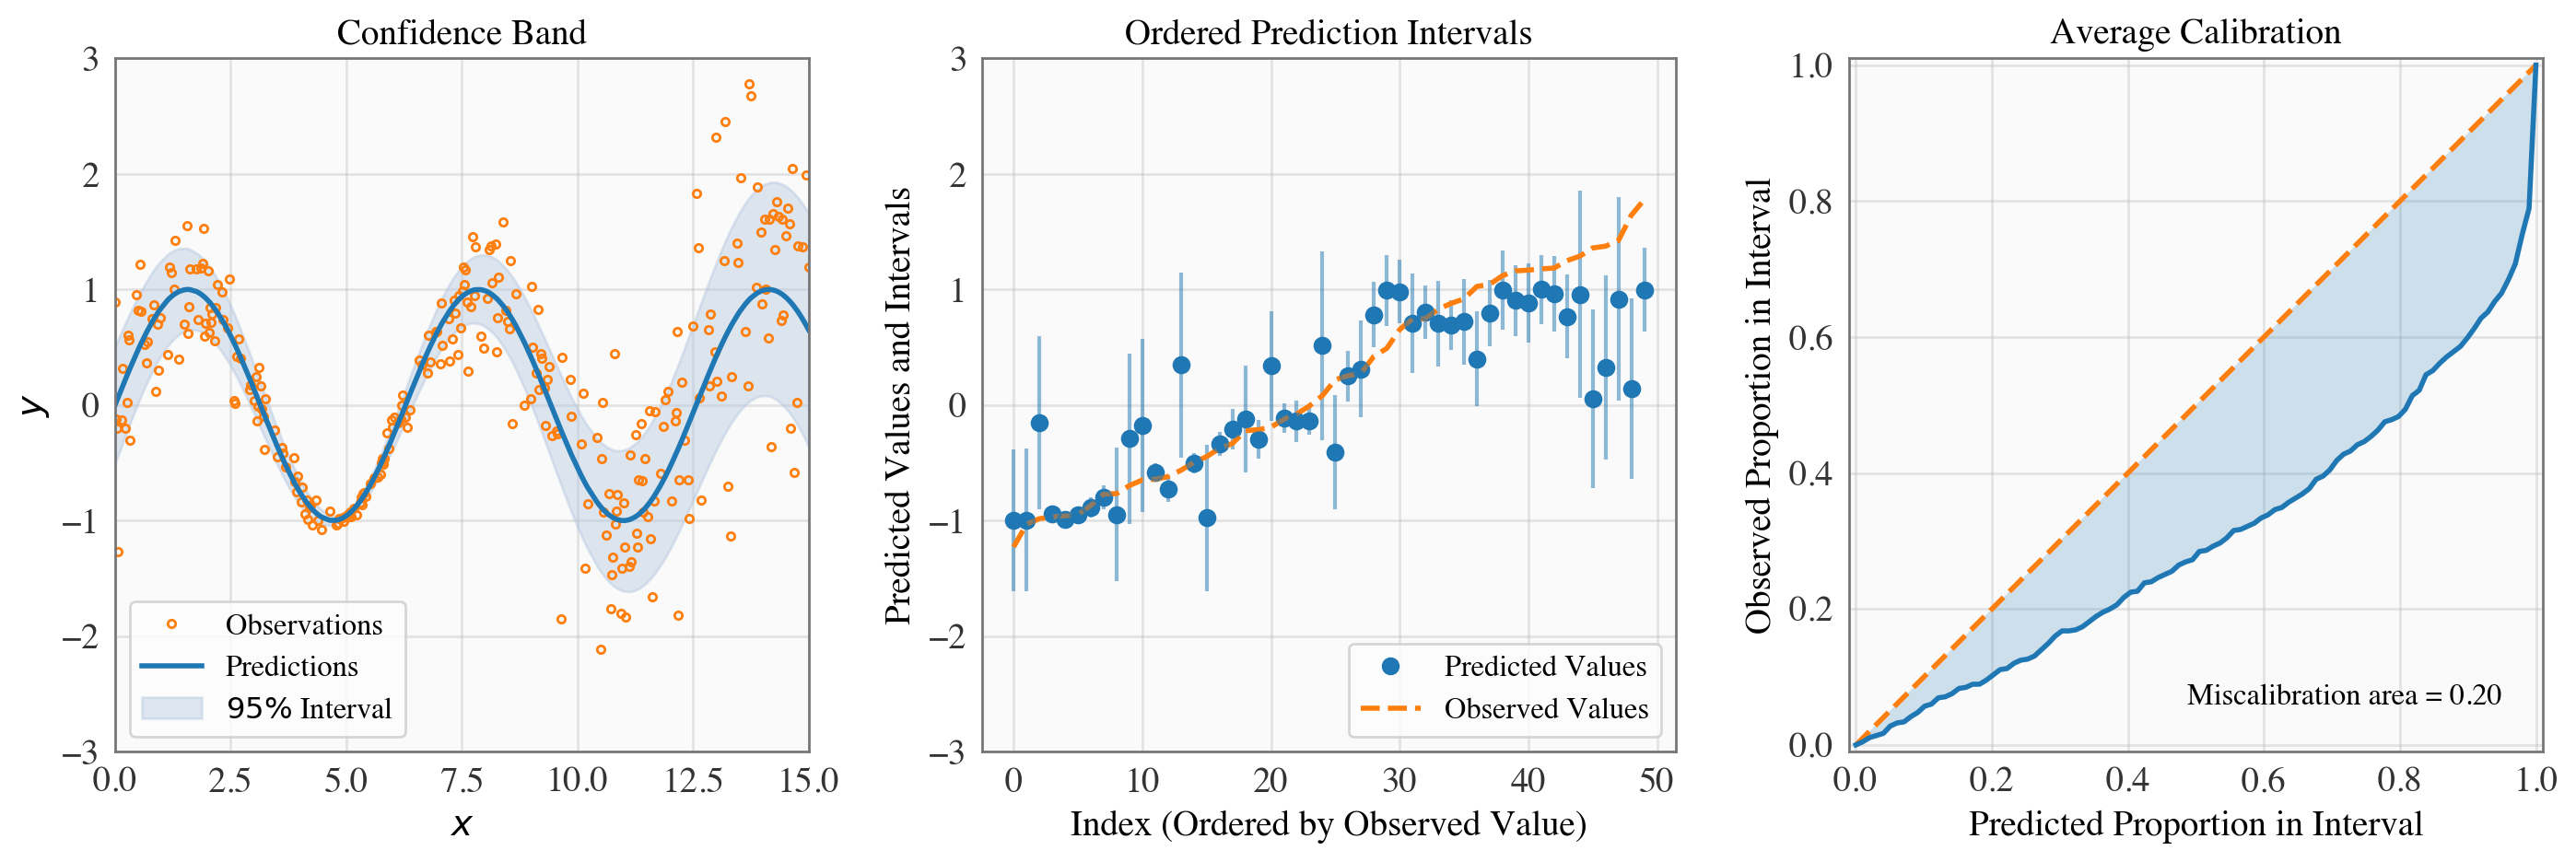

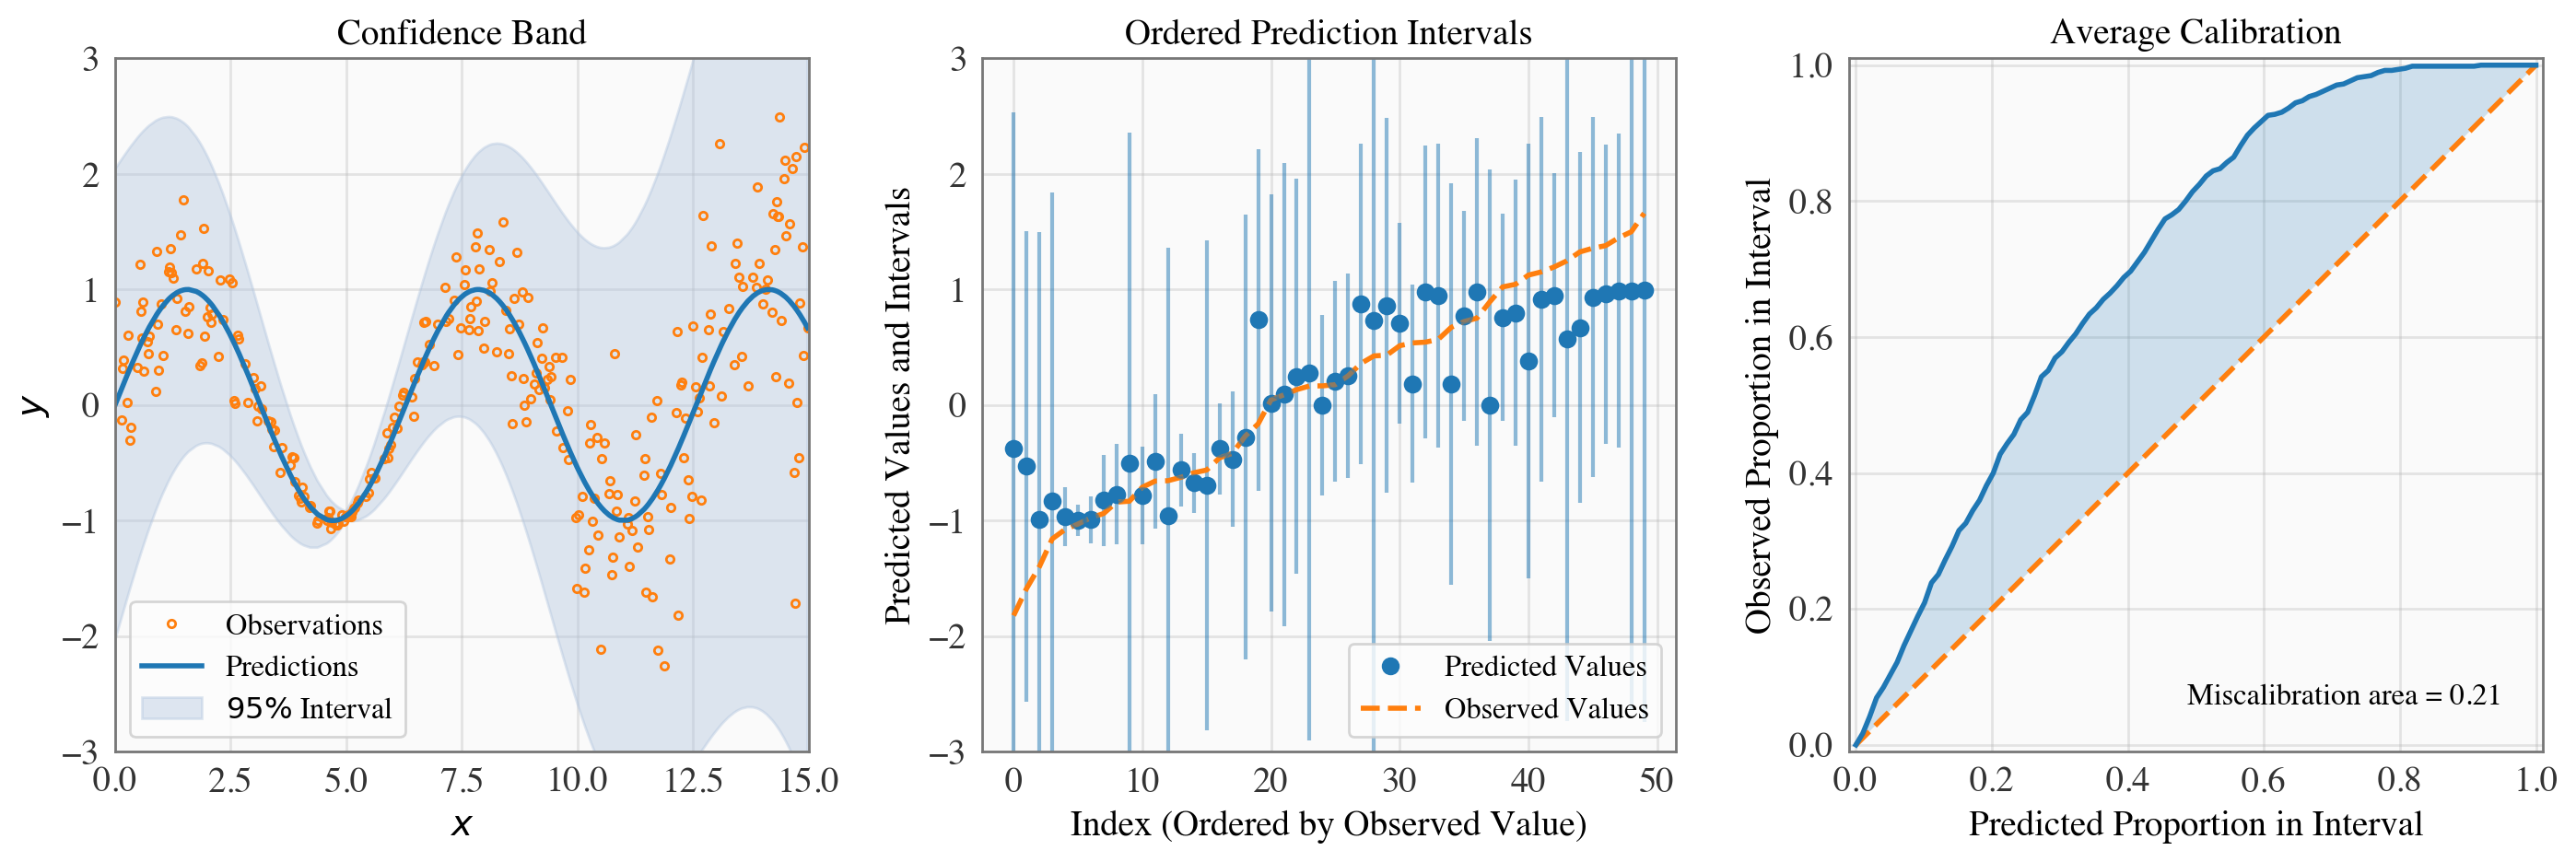

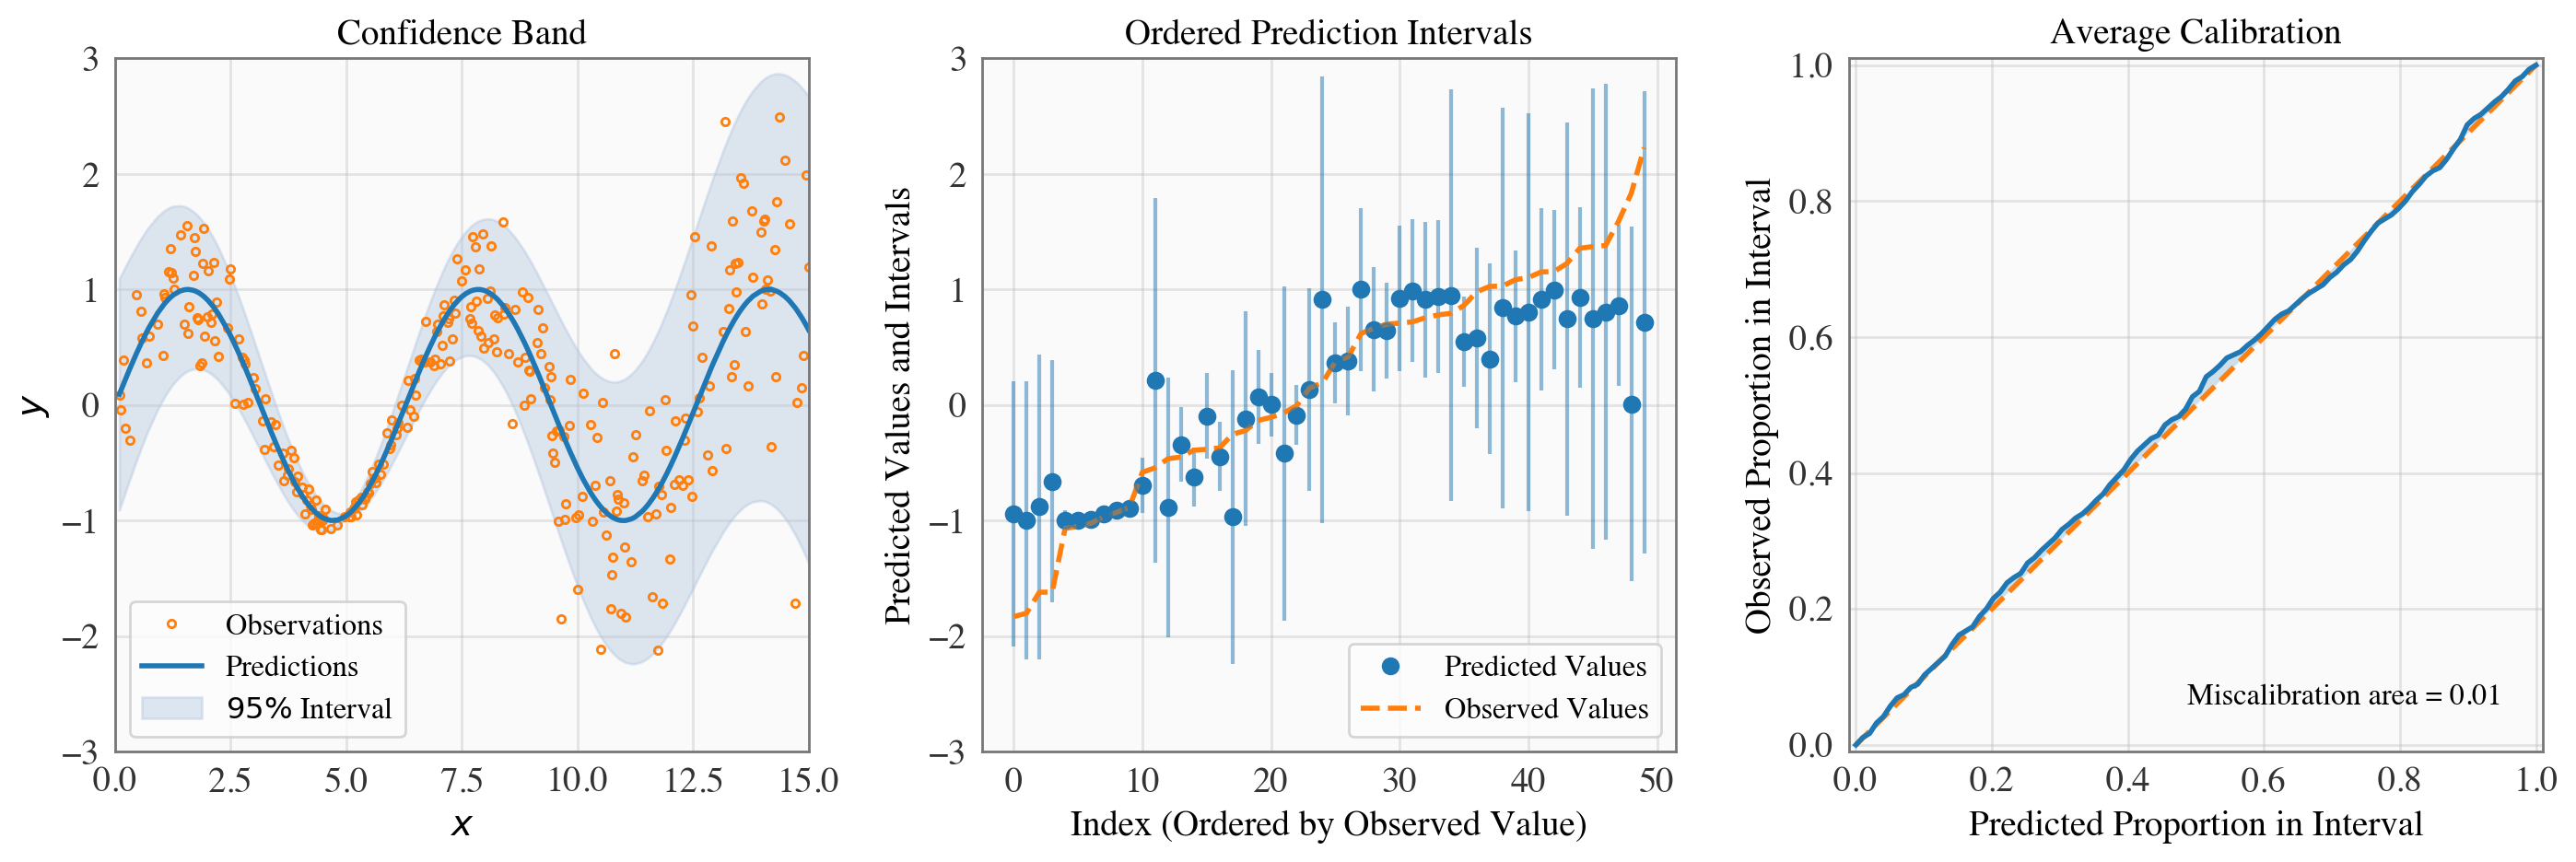

In [3]:
"""
Examples of code for visualizations.
"""

import numpy as np
import matplotlib.pyplot as plt
import uncertainty_toolbox as uct


# Set plot style
uct.viz.set_style()
uct.viz.update_rc("text.usetex", False)  # Set to True for system latex
uct.viz.update_rc("font.size", 14)  # Set font size
uct.viz.update_rc("xtick.labelsize", 14)  # Set font size for xaxis tick labels
uct.viz.update_rc("ytick.labelsize", 14)  # Set font size for yaxis tick labels

# Set random seed
np.random.seed(11)

# Generate synthetic predictive uncertainty results
n_obs = 650
f, std, y, x = uct.synthetic_sine_heteroscedastic(n_obs)

# Save figure (set to True to save)
savefig = False


def make_plots(pred_mean, pred_std, plot_save_str="row"):
    """Make set of plots."""

    ylims = [-3, 3]
    n_subset = 50

    fig, axs = plt.subplots(1, 3, figsize=(17, 8))

    # Make xy plot
    axs[0] = uct.plot_xy(
        pred_mean, pred_std, y, x, n_subset=300, ylims=ylims, xlims=[0, 15], ax=axs[0]
    )

    # Make ordered intervals plot
    axs[1] = uct.plot_intervals_ordered(
        pred_mean, pred_std, y, n_subset=n_subset, ylims=ylims, ax=axs[1]
    )

    # Make calibration plot
    axs[2] = uct.plot_calibration(pred_mean, pred_std, y, ax=axs[2])

    # Adjust subplots spacing
    fig.subplots_adjust(wspace=0.25)

    # Save figure
    if savefig:
        uct.viz.save_figure(plot_save_str, "svg", white_background=True)


# List of predictive means and standard deviations
pred_mean_list = [f]

pred_std_list = [
    std * 0.5,  # overconfident
    std * 2.0,  # underconfident
    std,  # correct
]

# Loop through, make plots, and compute metrics
idx_counter = 0
for i, pred_mean in enumerate(pred_mean_list):
    for j, pred_std in enumerate(pred_std_list):
        mace = uct.mean_absolute_calibration_error(pred_mean, pred_std, y)
        rmsce = uct.root_mean_squared_calibration_error(pred_mean, pred_std, y)
        ma = uct.miscalibration_area(pred_mean, pred_std, y)

        idx_counter += 1
        make_plots(pred_mean, pred_std, f"row_{idx_counter}")

        print(f"MACE: {mace}, RMSCE: {rmsce}, MA: {ma}")

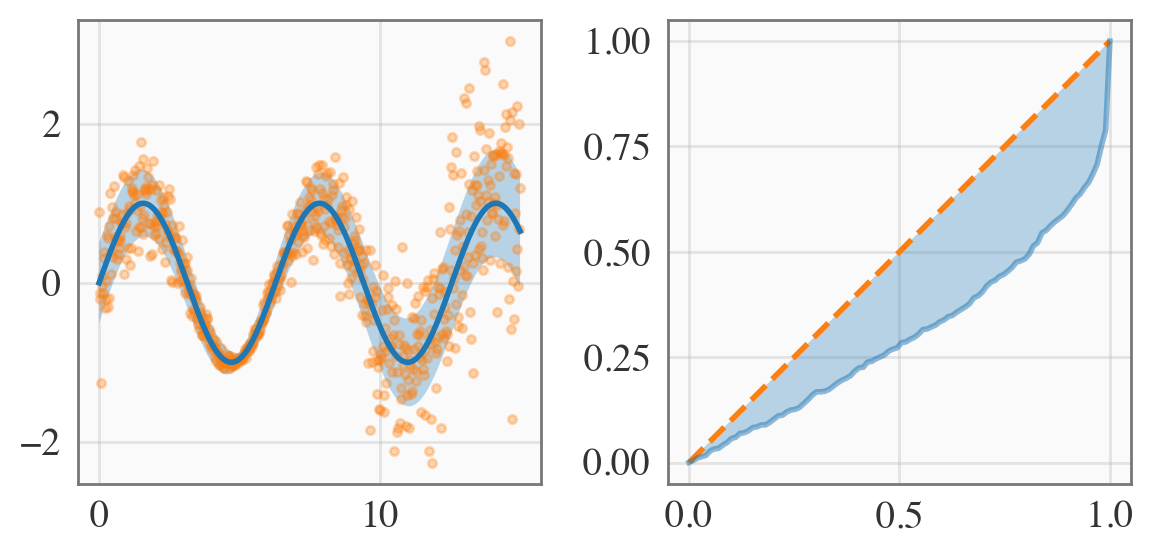

In [44]:
import scipy.stats as st


fig, axs = plt.subplots(ncols=2, figsize=(6, 3))

FILL_PARAMS = dict(color="C0", alpha=0.3, edgecolor="none")

axs[0].plot(x, y, ".", color="C1", alpha=0.3)
axs[0].plot(x, f, color="C0")
axs[0].fill_between(x, f - (std / 2) ** 0.5, f + (std / 2) ** 0.5, **FILL_PARAMS)

calibration_curve_x = np.linspace(0, 1, 100, endpoint=True)
calibration_curve_y = [0.0]
for p in calibration_curve_x[1:]:
    lower = st.norm.ppf(0.5 - p / 2, loc=f, scale=std * 0.5)
    upper = st.norm.ppf(0.5 + p / 2, loc=f, scale=std * 0.5)
    n_inside = np.count_nonzero((y < upper) & (y > lower))
    calibration_curve_y.append(n_inside / y.shape[0])

optimal_calibration_curve_y = calibration_curve_x.copy()
axs[1].plot(calibration_curve_x, optimal_calibration_curve_y, "--", color="C1")
axs[1].plot(calibration_curve_x, calibration_curve_y, "-", color="C0", alpha=0.5)
axs[1].fill_between(
    calibration_curve_x, optimal_calibration_curve_y, calibration_curve_y, **FILL_PARAMS
)

plt.tight_layout()
plt.show()